# Template for Model Evaluation

template written by Nisa Ulumuddin

evaluation done by Nisa Ulumuddin 

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
import advertools as adv
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words
import os
import numpy as np
import pandas as pd
import sklearn.metrics as met
from scipy.spatial.distance import euclidean
import sklearn.metrics as metrics
from random import randint

import func_similarityfunc as sim
import func_tfidf as tfidf
import func_datapreprocessing as pp
import func_predict as pred 
import func_eval as eve

In [2]:
rd_recipe = pd.read_csv('clean_recipe_data.csv')
eval_recipe = pd.read_csv('model_dataset.csv')

## Evaluation Functions 

For the evaluation of the model, we have created two evaluation functions. 

**************

### 1. Effectivity Function
The first evaluation function is called **Effectivity Function**. This function calculates the percentage of queried ingredients inside the recommended recipes outputted by the model. 

The syntax to use this function is shown below:

`percent_table = eve.effectivity_eval(Q, query,raw_recipe)`

where:
* `Q` is the list of recommended recipe indexes (of rd_recipe) outputted by the model
* `query` is the string of user query 
* `raw_recipe` is the dataframe of the recipe table 

and `percent_table` is a dataframe showing percentage values of how many ingredients in the query actually popped up in the recipes recommended by the model. 

***********

### 2. Precision/Recall Analysis Based on Model Dataset 

Unfortunately, it was highly difficult to obtain datasets which connects a query of ingredients to the clicking rate of recipes. Ideally, our team would conduct a survey of sufficient scale to gather this data. However, due to the limitations of time, we have been advised to generate a model dataset connected that is connected to a set of model queries. 

The dataset is loaded into the variable `eval_recipe`. It consists of 57 data points. Each recipe was labeled either 1 (relevant) or 0(irrelevant) to indicate whether it is a relevant recipe to the model query. We can then do statistical analysis based on these results (i.e. recall/precision type analysis)


#### Query List:

* Query 1:  beef, salt, pepper   
* Query 2: chicken, cream      
* Query 3: noodles, chicken   
* Query 4: beef, potatoes      

#### Score metric:
* 1 = fulfils query
* 0 = does not fulfil query

Here, we load the `eval_recipe` i.e. the model dataset

In [3]:
eval_recipe.head(3)

,index,recipe_id,recipe_name,user_id,rating,Query 1,Query 2,Query 3,Query 4,ingredients,cooking_directions
0,24,56648,Gravy potatoes,NaN,3,0,0,0,1,baking potatoes ground beef small onion conden...,{'directions': u'Prep\n5 m\nCook\n1 h 15 m\nRe...
1,25,74224,meat loaf pie,NaN,3,0,0,0,1,ground beef small onion egg ketchup worcesters...,{'directions': u'Prep\n15 m\nCook\n40 m\nReady...
2,26,70589,Serbian ground beef veggie potato bake,NaN,3,1,0,0,1,ground beef olive oil green bell pepper onion ...,{'directions': u'Prep\n25 m\nCook\n1 h\nReady ...


As you can see, each recipe has a score of 1 or 0 based on whether they are a relevant recipe to Query 1-4.
It is important to note that these scores were made arbitrarily based on the judgment of one DS member. Therefore we advise that the results of this evaluation to be taken with a grain of salt.

In this evaluation method, the recommendation model will vectorize the recipes in the model dataset, and match the query to the recipes in this dataset. By calling the evaluation function:

`[result, reordered_model_df] = PrecRec_eval(model_df,threshold, prediction_model)`

where `model_df` is eval_recipe , `threshold` is the number of results/recipes you want to evaluate for precision/recall analysis, and `prediction model` is the prediction model. The list of `prediction model` is inside the file **func_predict.py**

An example of the usage of this function is:

 `[result, reordered_model_df] = eve.PrecRec_eval(eval_recipe, 7, "cosine_similarity")`

 `result` is an array of 1s and 0s, i.e. 
 
 `[array([0, 0, 1, 0, 0, 0, 1], dtype=int64),
 array([1, 1, 1, 0, 1, 1, 0], dtype=int64),
 array([1, 0, 1, 0, 0, 0, 0], dtype=int64),
 array([1, 1, 0, 1, 0, 0, 1], dtype=int64)]`
 
 and `reorerdered_model_df` is a dataFrame of the model dataset, that is reordered according to its similarity score calculated by the model. It is listed in descending order 

which is an indication whether the first *n* recipes are relevant(1) or irrelevant(0) to queries 1 to 4. The first row belongs to results to query 1, and so on and so forth.

Taking the example of `array([1, 1, 0, 1, 0, 0, 1], dtype=int64)` , our result shows that recipe 1,2, 4 and 7 are relevant, while the rest are irrelevant. 



In our model dataset, there are only **7 recipes** which are relevant to each queries. Therefore, we can only evaluate the top 7 recipes as a maximum.

***********************************

# Evaluation of Model 1:
Details of Model 1: 
- The model vectorizes the 'cooking directions' text to represent the vector of the recipe
- cosine similarity function in func_predict.py was used 

In [4]:
processed_text = []    #processed text of the whole dataset
for text in rd_recipe['cooking_directions']:
    processed_text.append(word_tokenize(pp.preprocess(text)))

In [5]:
[D, DF, N] = tfidf.vectorize_corpus(processed_text)

The more extensive steps of evaluation are inside the file **evalbook_template_nisaulumuddin**. After much testing and discussion, we found that the Model Dataset that was curated was too biased to give us a representative measure of the model's performance. The details below summarizes the evaluation of our model:

Firstly, we want to define a couple of functions

In [6]:
def avg_m(val):
    return sum(val)/len(val)

In [7]:
#so that these steps can be called by one line...
def run_sim(user_query,k):
    [ result_index , result_score] = pred.cosine_similarity(k, user_query, D , DF, N)
    res_df = pd.DataFrame(columns = ['recipe_index','recipe_id','similarity_score',])
    res_df.loc[:, 'recipe_index'] = result_index
    res_df.loc[:, 'recipe_id'] = rd_recipe.loc[result_index,'recipe_id'].values.tolist()
    res_df.loc[:,'similarity_score'] = result_score*100
    print("The query is '{}' ".format(user_query))
    return res_df

In [8]:
# generates 4-ingredients lists by random
def genquadpairs(m, n):
    seen = set()

    a,b,c,d = randint(m, n), randint(m, n), randint(m, n), randint(m, n)

    while True:
        seen.add((a,b,c,d))
        yield (a,b,c,d)
        a,b,c,d = randint(m, n), randint(m, n), randint(m, n), randint(m, n)
        while (a,b,c,d) in seen:
            a,b,c,d,e = randint(m, n), randint(m, n), randint(m, n), randint(m, n)

In [9]:
user_query = "beef, potatoes, soy sauce, sugar,  "
q1 = run_sim(user_query,2000)
[ result_index , result_score] = pred.cosine_similarity(2000, user_query, D , DF, N)
eff_score = eve.effectivity_eval( result_index, user_query, rd_recipe)
eff_score.loc[:,"similarity_score"] = q1.loc[:,'similarity_score']
eff_score.rename({'percent': 'ingredient_match'}, axis=1, inplace=True)
max_score = eff_score['similarity_score'].max()
eff_score['norm_simscore']=eff_score['similarity_score'].apply(lambda x: x/max_score)
eff_score['binary_match'] = eff_score['ingredient_match'].apply(lambda x: 1 if x >=0.75 else 0)

ytrue = eff_score['binary_match'].values.tolist()
y_pred = eff_score['norm_simscore'].values.tolist()
fpr, tpr, threshold = metrics.roc_curve(ytrue,y_pred )
roc_auc = metrics.auc(fpr, tpr)



The query is 'beef, potatoes, soy sauce, sugar,  ' 


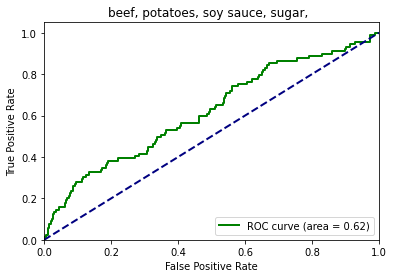

In [10]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="green",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)


plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(user_query)
plt.legend(loc="lower right")
plt.show()

Now we will create queries at random and analyze them to be able to do a sensitive analysis of this result. 

In [11]:
ingredients = ["chicken", "soy sauce", "chilli", "tomato", "potato", "pepper", "salt", "ginger", "garlic", "bread", "flour", "pasta", "cheese", "lettuce", "onion", "taco", "beef", "olive oil", "oil", "macaroni", "cream cheese","honey","sausage","cornflakes","bacon","jalapeno","egg","noodles","hoisin sauce","bread crumbs","honey","carrot","potatoes","carrot","butter","lemon"]

In [12]:
ing_list = pd.DataFrame(data=ingredients)


In [14]:
g = genquadpairs(0,35)
list(next(g))

[31, 4, 18, 5]

In [15]:
query_gen = []

for i in range(0,100):
    g = genquadpairs(0,35)
    query_g = ing_list.iloc[list(next(g)),:][0].values.tolist()
    query_gen.append(query_g)

In [17]:
query_gen[0:2]

[['bread crumbs', 'honey', 'chicken', 'potato'],
 ['chicken', 'ginger', 'potato', 'pepper']]

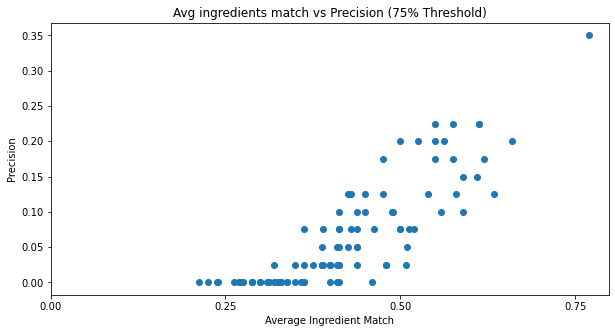

In [19]:
cumu_avg = []
querylist = []
preclist = []
ytrue_cum = []
eff_cumu = []
for f in range(0,len(query_gen)):
    user_query= query_gen[f]
    querylist.append(user_query)
    [ result_index , result_score] = pred.cosine_similarity(20, user_query, D , DF, N)
    eff_score = eve.effectivity_eval( result_index, user_query, rd_recipe)
    eff_true = eff_score["percent"].values.tolist()
    avg_score = avg_m(eff_true)
    cumu_avg.append(avg_score)
    eff_cumu.append(eff_true)
    y_pred = np.ones(20)
    y_true = []
    
    #for precision calculation, setting the threshold value to 75% match..
    for f in range(0,len(eff_true)):
        if eff_true[f] >= 0.75:
            y_true.append(1)
        else:
            y_true.append(0)
    ytrue_cum.append(y_true)
    prec = met.precision_score(y_true, y_pred, average='macro', zero_division = 0)
    preclist.append(prec)
    
d = {'query': querylist, 'avg_match': cumu_avg , 'prec':preclist}
test_20queries = pd.DataFrame(data=d)
#test_20queries.sort_values(by="avg_match",ascending=False)

plt.figure(figsize=(10, 5)) 
plt.scatter(x=test_20queries['avg_match'], y=test_20queries['prec'])
plt.title("Avg ingredients match vs Precision (75% Threshold)")
plt.ylabel("Precision")
plt.xlabel("Average Ingredient Match")
plt.xticks(np.arange(0, 1, step=0.25))
plt.show()

In [22]:
roc_cumu = []
cumu_avg = []
for f in range(0,10): 
    user_query= query_gen[f]
    [ result_index , result_score] = pred.cosine_similarity(2000, user_query, D , DF, N)
    eff_score = eve.effectivity_eval( result_index, user_query, rd_recipe)
    
    sim_core = result_score  #cosine similarity score
    match_score = eff_score['percent'].values.tolist()  #ingredient % match score
    
    #calculating average match score
    avg_score = avg_m(match_score[0:7])
    cumu_avg.append(avg_score)
    
    #calculating y_true binaries and normalized y_pred
    max_score = np.max(sim_core)
    norm_sims = sim_core/max_score
    bin_match = []
    for i in match_score:
        if i >= 0.75:
            bin_match.append(1)
        else:
            bin_match.append(0)
    
    ytrue = bin_match
    y_pred = norm_sims
    fpr, tpr, threshold = metrics.roc_curve(ytrue,y_pred )
    roc_auc = metrics.auc(fpr, tpr)
    roc_cumu.append(roc_auc)
    

In [29]:
print("This is the list of ROC AUC for the model performance based on 10 random queries we have processed: {}".format(roc_cumu))
print("This is the average ROC AUC based on the 10 runs: {}".format(avg_m(roc_cumu)))

This is the list of ROC AUC for the model performance based on 10 random queries we have processed: [0.8565140845070423, 0.651253007237951, 0.7647256564449258, 0.628427623623231, 0.5649063101696769, 0.882230664468497, 0.8689344672336168, 0.7798984771573605, 0.8094043437746397, 0.589362206031266]
This is the average ROC AUC based on the 10 runs: 0.7395656840648206


In [28]:
print("This is the list of match average for the model performance of 10 random queries, for the top 7 recipes: {}".format(cumu_avg))
print("This is the average match average based on the 10 runs: {}".format(avg_m(cumu_avg)))

This is the list of match average for the model performance of 10 random queries, for the top 7 recipes: [0.39999999999999997, 0.42857142857142855, 0.35714285714285715, 0.4761904761904762, 0.5714285714285714, 0.42857142857142866, 0.2571428571428572, 0.39285714285714285, 0.3142857142857142, 0.48571428571428577]
This is the average match average based on the 10 runs: 0.4111904761904762


# Evaluation of Model 2

Details of Model 2: 
- The model vectorizes both the 'cooking directions' + 'ingredients' text to represent the vector of the recipe
- cosine similarity function in func_predict.py was used 

Loading the model...

In [30]:
rd_recipe['dir_and_ingredients'] = rd_recipe['cooking_directions'] + rd_recipe['ingredients']

In [33]:
processed_text_2 = []    #processed text of the whole dataset
for text in rd_recipe['dir_and_ingredients']:
    processed_text_2.append(word_tokenize(pp.preprocess(text)))

In [34]:
[D_2, DF_2, N_2] = tfidf.vectorize_corpus(processed_text_2)

In [ ]:
[ result_index_2 , result_score_2] = pred.cosine_similarity(7, user_query, D_2 , DF_2, N_2)

In [ ]:
result_index_2

In [35]:
roc_cumu_2= []
cumu_avg_2 = []
for f in range(0,10): 
    user_query= query_gen[f]
    [ result_index_2 , result_score_2] = pred.cosine_similarity(2000, user_query, D_2 , DF_2, N_2)
    eff_score = eve.effectivity_eval( result_index_2, user_query, rd_recipe)
    
    sim_core = result_score_2  #cosine similarity score
    match_score = eff_score['percent'].values.tolist()  #ingredient % match score
    
    #calculating average match score
    avg_score = avg_m(match_score[0:7])
    cumu_avg_2.append(avg_score)
    
    #calculating y_true binaries and normalized y_pred
    max_score = np.max(sim_core)
    norm_sims = sim_core/max_score
    bin_match = []
    for i in match_score:
        if i >= 0.75:
            bin_match.append(1)
        else:
            bin_match.append(0)
    
    ytrue = bin_match
    y_pred = norm_sims
    fpr, tpr, threshold = metrics.roc_curve(ytrue,y_pred )
    roc_auc = metrics.auc(fpr, tpr)
    roc_cumu_2.append(roc_auc)
    

In [36]:
print("This is the list of ROC AUC for the model performance based on 10 random queries we have processed: {}".format(roc_cumu_2))
print("This is the average ROC AUC based on the 10 runs: {}".format(avg_m(roc_cumu_2)))

This is the list of ROC AUC for the model performance based on 10 random queries we have processed: [0.9447518443997318, 0.682813862249346, 0.8143563512361467, 0.6511451779353508, 0.5610618711196745, 0.8829145728643216, 0.9949974987493746, 0.8209137055837564, 0.9216543616945021, 0.5790104999652319]
This is the average ROC AUC based on the 10 runs: 0.7853619745797438


In [37]:
print("This is the list of match average for the model performance of 10 random queries, for the top 7 recipes: {}".format(cumu_avg_2))
print("This is the average match average based on the 10 runs: {}".format(avg_m(cumu_avg_2)))

This is the list of match average for the model performance of 10 random queries, for the top 7 recipes: [0.5714285714285714, 0.42857142857142855, 0.5, 0.5952380952380952, 0.7142857142857143, 0.6285714285714284, 0.48571428571428577, 0.39285714285714285, 0.2857142857142857, 0.4000000000000001]
This is the average match average based on the 10 runs: 0.5002380952380954


Do an evaluation of Model 2!

# Evaluation of Model 3

Details of Model 3: 
- The model vectorizes the 'cooking directions' text to represent the vector of the recipe
- eucledian spatial distance was used to calculate vector distance  

In [38]:
from scipy.spatial.distance import euclidean

In [ ]:
[ result_index_3 , result_score_3] = pred.euclidean_similarity(7, user_query, D , DF, N)

In [39]:
roc_cumu_3= []
cumu_avg_3 = []
for f in range(0,10): 
    user_query= query_gen[f]
    [ result_index_3 , result_score_3] = pred.euclidean_similarity(2000, user_query, D , DF, N)
    eff_score = eve.effectivity_eval( result_index_3, user_query, rd_recipe)
    
    sim_core = result_score_3  #cosine similarity score
    match_score = eff_score['percent'].values.tolist()  #ingredient % match score
    
    #calculating average match score
    avg_score = avg_m(match_score[0:7])
    cumu_avg_3.append(avg_score)
    
    #calculating y_true binaries and normalized y_pred
    max_score = np.max(sim_core)
    norm_sims = sim_core/max_score
    bin_match = []
    for i in match_score:
        if i >= 0.75:
            bin_match.append(1)
        else:
            bin_match.append(0)
    
    ytrue = bin_match
    y_pred = norm_sims
    fpr, tpr, threshold = metrics.roc_curve(ytrue,y_pred )
    roc_auc = metrics.auc(fpr, tpr)
    roc_cumu_3.append(roc_auc)
    

C:\Users\Nisa Ulumuddin\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Nisa Ulumuddin\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Nisa Ulumuddin\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Nisa Ulumuddin\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Nisa Ulumuddin\anaconda3\lib\site-packages\sklearn\metrics\_ran

In [41]:
print("This is the list of ROC AUC for the model performance based on 10 random queries we have processed: {}".format(roc_cumu_3))
print("This is the average ROC AUC based on the 10 runs: {}".format(avg_m(roc_cumu_3)))

This is the list of ROC AUC for the model performance based on 10 random queries we have processed: [nan, nan, nan, nan, 0.2955455455455455, nan, nan, nan, nan, 0.38069034517258626]
This is the average ROC AUC based on the 10 runs: nan


In [42]:
print("This is the list of match average for the model performance of 10 random queries, for the top 7 recipes: {}".format(cumu_avg_3))
print("This is the average match average based on the 10 runs: {}".format(avg_m(cumu_avg_3)))

This is the list of match average for the model performance of 10 random queries, for the top 7 recipes: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
This is the average match average based on the 10 runs: 0.0


Do an evaluation of Model 3!